In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [17]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv')
data

,nace,lpk,hourly_rate,esize_class_nc,gen_F,gen_M,age_class_nc,education_nc,lpk1,lpk2,lpk1_nc,outlier_iqr_lpk1_nc,nace_nc
0,C,722,8.13,0,0,1,0,1,7,72,478,False,0
1,C,721,8.20,0,0,1,1,1,7,72,478,False,0
2,C,722,8.20,0,0,1,0,1,7,72,478,False,0
3,C,334,2.51,0,1,0,1,1,3,33,300,False,0
4,M,522,2.19,1,1,0,1,1,5,52,500,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36508,N,711,2.84,0,0,1,0,1,7,71,478,False,0
36509,N,711,2.84,0,0,1,0,1,7,71,478,False,0
36510,N,711,2.84,0,0,1,2,1,7,71,478,False,0
36511,N,711,2.84,0,0,1,0,1,7,71,478,False,0


# Data selection and filtering

Select lpk level

In [18]:
lpk_level = 'lpk1_nc'
#Valid options: 'lpk', 'lpk1', 'lpk2', 'lpk1_nc'

Include outliers?

In [19]:
remove_outliers = True
if remove_outliers == True:
    data=data.query('outlier_iqr_lpk1_nc==False')
    print('Outliers removed')
else:
    print('Outliers retained')

data.shape

Outliers removed


(35019, 13)

Remove columns from X and y

In [20]:
remove_col = ['nace', 'lpk', 'lpk1', 'lpk2', 'lpk1_nc', 'outlier_iqr_lpk1_nc']
remove_col.remove(lpk_level)

In [21]:
data_sf = pd.get_dummies(data, prefix=lpk_level ,columns=[lpk_level])
data_sf.drop(columns=remove_col, inplace=True )
data_sf

,hourly_rate,esize_class_nc,gen_F,gen_M,age_class_nc,education_nc,nace_nc,lpk1_nc_100,lpk1_nc_200,lpk1_nc_300,lpk1_nc_478,lpk1_nc_500,lpk1_nc_900
0,8.13,0,0,1,0,1,0,0,0,0,1,0,0
1,8.20,0,0,1,1,1,0,0,0,0,1,0,0
2,8.20,0,0,1,0,1,0,0,0,0,1,0,0
3,2.51,0,1,0,1,1,0,0,0,1,0,0,0
4,2.19,1,1,0,1,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36508,2.84,0,0,1,0,1,0,0,0,0,1,0,0
36509,2.84,0,0,1,0,1,0,0,0,0,1,0,0
36510,2.84,0,0,1,2,1,0,0,0,0,1,0,0
36511,2.84,0,0,1,0,1,0,0,0,0,1,0,0


In [22]:
y = data_sf['hourly_rate']
X = data_sf.drop(columns='hourly_rate')
y.shape , X.shape

((35019,), (35019, 12))

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=0)
y_train.shape, y_test.shape

((28015,), (7004,))

## Simple Linear Regression

### Model and predictions

In [24]:
from sklearn.linear_model import LinearRegression
model_LR = LinearRegression(fit_intercept=True)
model_LR.fit(X=X_train,y=y_train)
y_train_pred = model_LR.predict(X_train)
y_test_pred = model_LR.predict(X_test)

In [25]:
def merge_prediction_data(labels, prediction, data):
    """Merge model prediction with initial data based on indexes in train and test sets"""
    df=labels.to_frame()
    df['predicted']=prediction
    df_w_data =pd.merge(df, data, left_index=True, right_index=True, indicator=False)
    df_w_data.rename(columns={'hourly_rate_x':'hourly_rate'}, inplace=True)
    df_w_data.drop(columns='hourly_rate_y', inplace=True)
    return df_w_data

In [26]:
train=merge_prediction_data(y_train, y_train_pred, data)
train

,hourly_rate,predicted,nace,lpk,esize_class_nc,gen_F,gen_M,age_class_nc,education_nc,lpk1,lpk2,lpk1_nc,outlier_iqr_lpk1_nc,nace_nc
5416,4.99,6.528320,O,242,1,0,1,0,2,2,24,200,False,0
30529,5.58,6.336426,Q,222,1,1,0,2,2,2,22,200,False,0
13340,6.79,9.051270,D,132,1,0,1,2,2,1,13,100,False,0
35419,6.53,6.680176,P,263,1,1,0,1,3,2,26,200,False,0
17487,5.50,4.643555,H,833,1,0,1,0,1,8,83,478,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21620,4.49,6.148926,H,334,1,0,1,2,2,3,33,300,False,0
33459,2.24,3.393555,C,331,0,1,0,2,1,3,33,300,False,0
31633,2.87,5.762207,H,833,1,0,1,2,2,8,83,478,False,0
22138,2.21,4.704590,R,342,0,0,1,2,2,3,34,300,False,0


In [27]:
test=merge_prediction_data(y_test, y_test_pred, data)
test

,hourly_rate,predicted,nace,lpk,esize_class_nc,gen_F,gen_M,age_class_nc,education_nc,lpk1,lpk2,lpk1_nc,outlier_iqr_lpk1_nc,nace_nc
30645,4.00,4.977051,R,242,0,1,0,0,3,2,24,200,False,0
3256,8.86,9.136230,O,111,1,0,1,0,3,1,11,100,False,0
15101,2.73,3.091797,N,422,0,1,0,0,2,4,42,478,False,0
36348,7.17,5.944824,R,251,0,0,1,1,3,2,25,200,False,0
359,8.74,5.217285,C,214,1,1,0,0,1,2,21,200,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26524,7.46,6.354492,K,331,1,1,0,0,3,3,33,300,False,1
30952,2.19,2.343262,S,514,0,1,0,2,1,5,51,500,False,0
19434,3.36,6.488281,N,121,0,0,1,0,1,1,12,100,False,0
455,3.51,3.584473,C,933,1,0,1,2,0,9,93,900,False,0


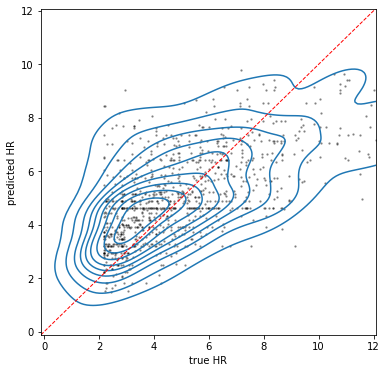

In [28]:
r = range(500,1500) #subseting for time saving
plt.figure(figsize = (6,6))
sns.scatterplot(data=test.iloc[r], x='hourly_rate', y='predicted',  s=5, color='black', alpha=0.5)
sns.kdeplot(data=test.iloc[r], x='hourly_rate', y='predicted')
plt.xlim(plt.ylim())
plt.xlabel('true HR')
plt.ylabel('predicted HR')
plt.plot(plt.ylim(), plt.ylim(), linestyle='--', color='r', lw=1, scalex=False, scaley=False);

In [29]:
print('Train: RMSE=', np.sqrt(mean_squared_error(train['hourly_rate'], train['predicted'])).round(2),
    ' R2=', r2_score(train['hourly_rate'], train['predicted']).round(2))

print('Test: RMSE=', np.sqrt(mean_squared_error(test['hourly_rate'], test['predicted'])).round(2),
    ' R2=', r2_score(test['hourly_rate'], test['predicted']).round(2))

Train: RMSE= 2.03  R2= 0.4
Test: RMSE= 2.03  R2= 0.4


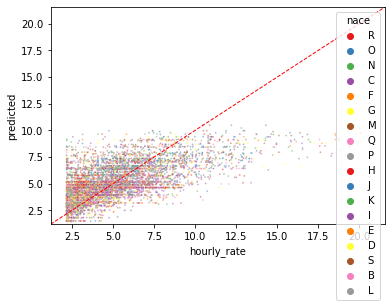

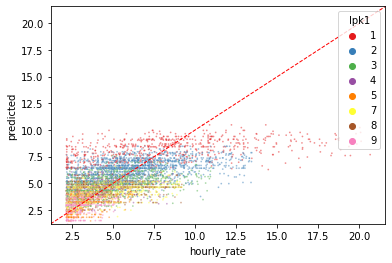

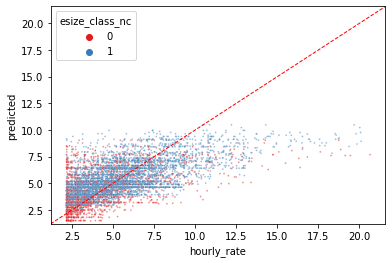

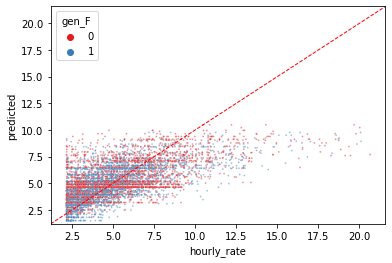

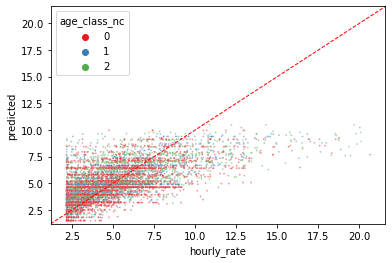

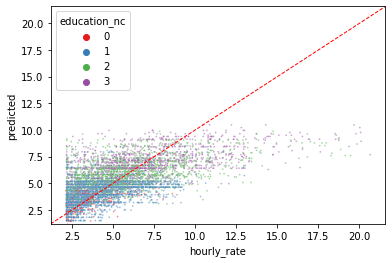

In [30]:
for feature in ['nace', 'lpk1',  'esize_class_nc', 'gen_F', 'age_class_nc', 'education_nc']:
    sns.scatterplot(data=test, x='hourly_rate', y='predicted', s=3, hue=feature, alpha=0.5, palette='Set1')
    plt.ylim(plt.xlim())
    plt.plot(plt.xlim(), plt.ylim(), linestyle='--', color='r', lw=1, scalex=False, scaley=False)
    plt.show();